<a href="https://colab.research.google.com/github/SNEHA-CHAUDHARY03/CNN/blob/main/lung_and_colon_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: snehachaudhary03
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images


100%|██████████| 1.76G/1.76G [00:10<00:00, 188MB/s] 


In [ ]:
!ls -lh


total 8.0K
drwxr-xr-x 3 root root 4.0K Jun  7 11:08 lung-and-colon-cancer-histopathological-images
drwxr-xr-x 1 root root 4.0K Jun  5 13:38 sample_data


In [ ]:
import os

for root, dirs, files in os.walk("/content/lung-and-colon-cancer-histopathological-images"):
    print(root, len(files))



/content/lung-and-colon-cancer-histopathological-images 0
/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set 0
/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets 0
/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca 5000
/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n 5000
/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets 0
/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca 5000
/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc 5000
/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n 5000


In [ ]:
import os
import shutil

# Source class directories
src_dirs = [
    "/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca",
    "/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n",
    "/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca",
    "/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n",
    "/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc"
]

# Destination base folder
dst_base = "/content/dataset/merged"

# Create merged dataset directory
os.makedirs(dst_base, exist_ok=True)

# Copy files from each class folder into its new subfolder
for src in src_dirs:
    class_name = os.path.basename(src)
    dst = os.path.join(dst_base, class_name)
    os.makedirs(dst, exist_ok=True)

    for file in os.listdir(src):
        src_file = os.path.join(src, file)
        dst_file = os.path.join(dst, file)
        shutil.copy(src_file, dst_file)

print("✅ All class folders merged successfully into:", dst_base)


✅ All class folders merged successfully into: /content/dataset/merged


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# 1️⃣ Data generators (adjust paths & image size as needed)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/dataset/merged',  # merged folder you created
    target_size=(250, 250),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    '/content/dataset/merged',
    target_size=(250, 250),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# 2️⃣ Build CNN model

model = Sequential([
    layers.Conv2D(32, (2, 2), activation="relu", input_shape=(250, 250, 3), padding="valid"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding="valid"),

    layers.Conv2D(64, (2, 2), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (2, 2), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (2, 2), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (2, 2), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(1024, (2, 2), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(1024, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(5, activation="softmax")  # 5 classes for your dataset
])

model.summary()

# 3️⃣ Compile model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# 4️⃣ Callbacks

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    "model_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

# 5️⃣ Train model

history = model.fit(
    train_generator,
    epochs=11,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint]
)


Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 249, 249, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 249, 249, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 123, 123, 64)   │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 123, 123, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 29, 29, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 512)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 13, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 1024)     │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 7,663,845 (29.24 MB)

 Trainable params: 7,656,229 (29.21 MB)

 Non-trainable params: 7,616 (29.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/11
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7918 - loss: 0.5522
Epoch 1: saving model to model_epoch_01.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 134s 96ms/step - accuracy: 0.7919 - loss: 0.5521 - val_accuracy: 0.9416 - val_loss: 0.1518
Epoch 2/11
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9073 - loss: 0.2468
Epoch 2: saving model to model_epoch_02.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 91ms/step - accuracy: 0.9073 - loss: 0.2468 - val_accuracy: 0.9664 - val_loss: 0.0984
Epoch 3/11
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9355 - loss: 0.1701
Epoch 3: saving model to model_epoch_03.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 115s 92ms/step - accuracy: 0.9355 - loss: 0.1701 - val_accuracy: 0.9618 - val_loss: 0.1045
Epoch 4/11
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9490 - loss: 0.1389
Epoch 4: saving model to model_epoch_04.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 115s 92ms/step - accuracy: 0.9490 - loss: 0.1389 - val_accuracy

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.9966 - loss: 0.0112
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9891 - loss: 0.0318


Train Accuracy: 0.9963
Validation Accuracy: 0.9856


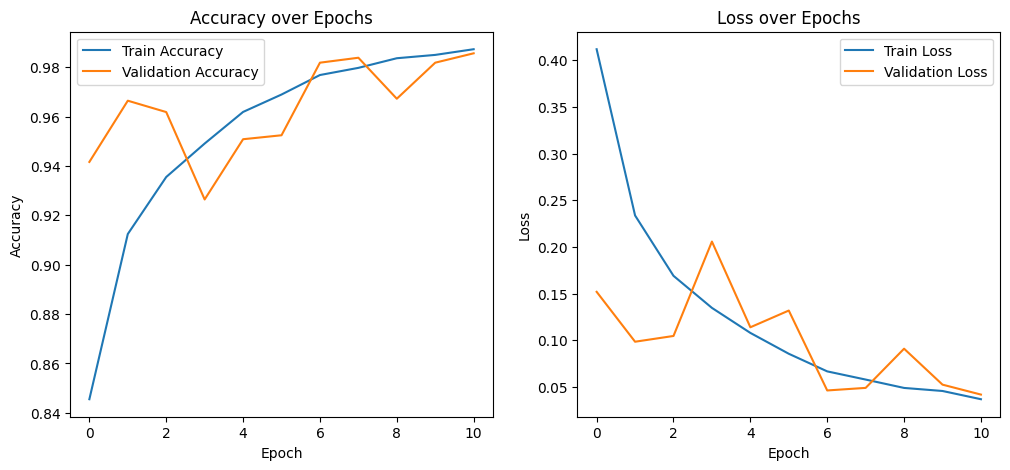

313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step


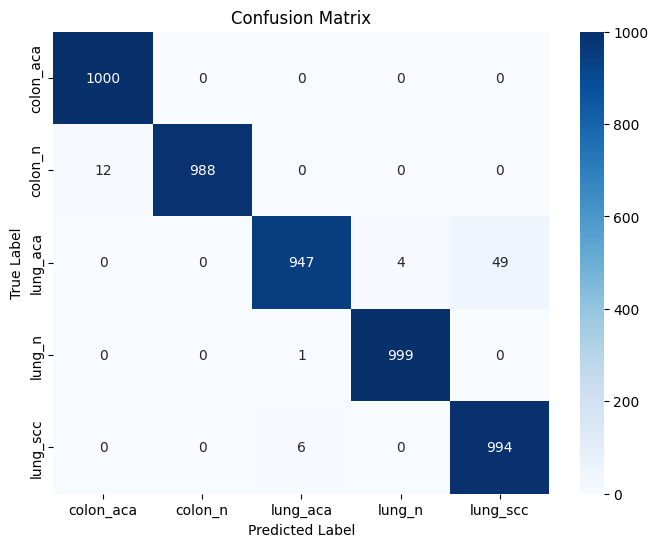

Classification Report:
              precision    recall  f1-score   support

   colon_aca       0.99      1.00      0.99      1000
     colon_n       1.00      0.99      0.99      1000
    lung_aca       0.99      0.95      0.97      1000
      lung_n       1.00      1.00      1.00      1000
    lung_scc       0.95      0.99      0.97      1000

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report

# 1️⃣ Evaluate on train and validation generators
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)  # use val_generator not test_generator

print(f'Train Accuracy: {train_acc:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')

# 2️⃣ Save the trained model
model.save('lung_colon_multiclass.h5')

# 3️⃣ Prediction helper function (adjusted for multiclass)
def predict_image(model, img_path, class_indices):
    img = image.load_img(img_path, target_size=(250, 250))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds, axis=1)[0]

    # Map index back to class name
    idx_to_class = {v: k for k, v in class_indices.items()}
    predicted_label = idx_to_class[pred_class_idx]

    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

# Example usage:
# predict_image(model, "/content/dataset/merged/lung_n/some_image.jpeg", train_generator.class_indices)

# 4️⃣ Plot training history
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 5️⃣ Confusion matrix & classification report on validation data
# Predict classes for validation set
val_preds = model.predict(val_generator)
val_preds_labels = np.argmax(val_preds, axis=1)

cm = confusion_matrix(val_generator.classes, val_preds_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(val_generator.classes, val_preds_labels, target_names=val_generator.class_indices.keys()))
